# Dataset Description

## Overview

The data has been split into two groups:

- **training set** (`train.csv`)
- **test set** (`test.csv`)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include **`gender_submission.csv`**, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

---

## Data Dictionary

| Variable  | Definition                                                         | Key               |
|-----------|--------------------------------------------------------------------|-------------------|
| survival  | Survival                                                           | 0 = No, 1 = Yes   |
| pclass    | Ticket class                                                       | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex       | Sex                                                                |                   |
| age       | Age in years                                                       |                   |
| sibsp     | # of siblings / spouses aboard the Titanic                         |                   |
| parch     | # of parents / children aboard the Titanic                         |                   |
| ticket    | Ticket number                                                      |                   |
| fare      | Passenger fare                                                     |                   |
| cabin     | Cabin number                                                       |                   |
| embarked  | Port of Embarkation                                                | C = Cherbourg, Q = Queenstown, S = Southampton |

---

## Variable Notes

- **pclass**: A proxy for socio-economic status (SES)
  - 1st = Upper  
  - 2nd = Middle  
  - 3rd = Lower  

- **age**: Age is fractional if less than 1. If the age is estimated, it is in the form of `xx.5`.

- **sibsp**: The dataset defines family relations in this way:
  - **Sibling** = brother, sister, stepbrother, stepsister  
  - **Spouse** = husband, wife (mistresses and fiancés were ignored)  

- **parch**: The dataset defines family relations in this way:
  - **Parent** = mother, father  
  - **Child** = daughter, son, stepdaughter, stepson  
  - Some children travelled only with a nanny, therefore `parch = 0` for them.

- **embarked**: Port of Embarkation
  - **C** = Cherbourg  
  - **Q** = Queenstown  
  - **S** = Southampton  


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
import seaborn as sns

%matplotlib inline

In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df  = pd.read_csv("/kaggle/input/titanic/test.csv")
y_test   = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
train_df = train_df.set_index('PassengerId')
test_df  = test_df.set_index('PassengerId')
y_test   = y_test.set_index('PassengerId')
train_df.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


---
## EDA

In [3]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
train_df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

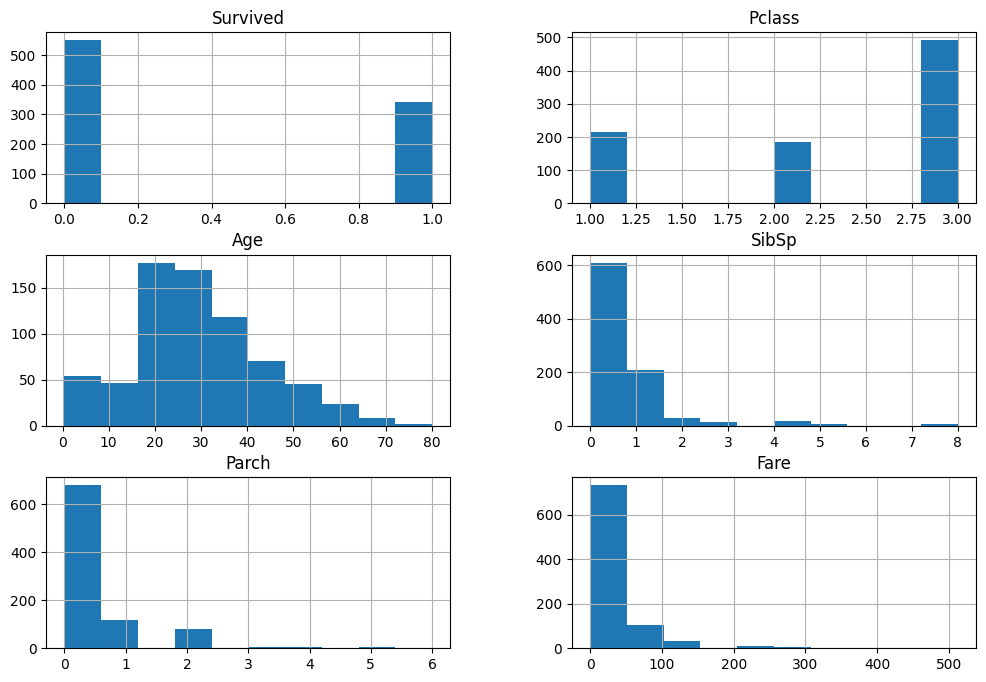

In [6]:
train_df.hist(figsize=(12,8))

---
## Pipeline

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

In [8]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),    
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [9]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]
target = 'Survived'
preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [10]:
X_train = preprocess_pipeline.fit_transform(train_df)
X_train

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [11]:
y_train = train_df[target]
y_test  = y_test[target]

---
## Model

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = {
    'logistic': {
        'model': LogisticRegression(max_iter=1000),
        'use_scaled': True,
        'params': {'C': np.logspace(-4, 4, 20), 'solver': ['lbfgs', 'liblinear']}
    },
    'rf': {
        'model': RandomForestClassifier(random_state=42),
        'use_scaled': False,
        'params': {'n_estimators': [100, 150, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 8]}
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'use_scaled': True,
        'params': {'n_neighbors': [3, 4, 5], 'weights': ['uniform', 'distance']}
    },
    'svm': {
        'model': SVC(probability=True),
        'use_scaled': True,
        'params': {'C': np.logspace(-3, 3), 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}
    }
}

In [13]:
# Trabajar los hiperparámetros
results = []
best_models = {}
for model_name, mp in models.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=3, scoring='f1_weighted', n_jobs=-1)
    clf.fit(X_train, y_train)
    results.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_models[model_name] = clf.best_estimator_
    print(f'{model_name} completed')

logistic completed
rf completed
knn completed
svm completed


---
## Evaluación del modelo

In [14]:
df_results = pd.DataFrame(results)

df_results

,model,best_score,best_params
0,logistic,0.798414,"{'C': 0.08858667904100824, 'solver': 'lbfgs'}"
1,rf,0.823757,"{'max_depth': 20, 'min_samples_split': 8, 'n_e..."
2,knn,0.789610,"{'n_neighbors': 4, 'weights': 'uniform'}"
3,svm,0.829241,"{'C': 2.0235896477251574, 'gamma': 'auto', 'ke..."


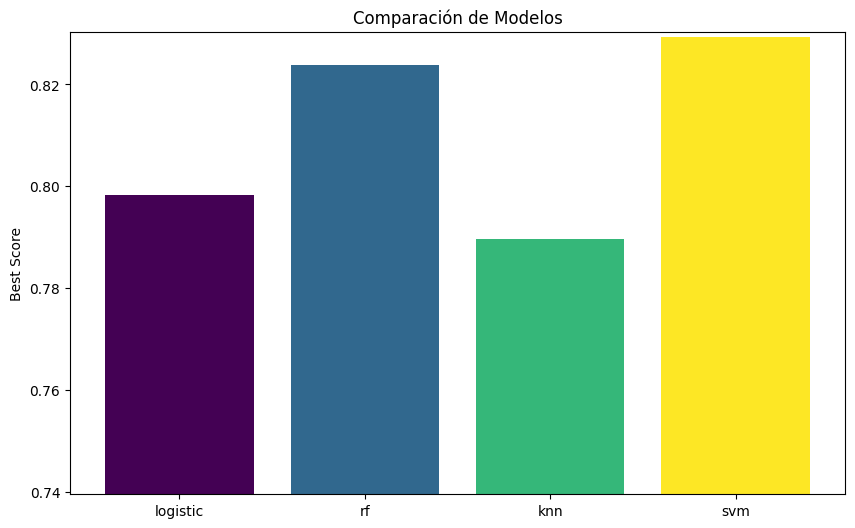

In [15]:
model_names = [result['model'] for result in results]
model_scores = [result['best_score'] for result in results]

colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

plt.figure(figsize=(10, 6))
plt.bar(model_names, model_scores, color=colors)
plt.ylim(min(model_scores) - 0.05, max(model_scores) + 0.001)
plt.ylabel('Best Score')
plt.title('Comparación de Modelos')
plt.show()

In [16]:
from sklearn.metrics import accuracy_score, f1_score

for model_name, model in best_models.items():
    model_predic = model.predict(X_train)
    accuracy = accuracy_score(y_train, model_predic)
    f1 = f1_score(y_train, model_predic, average='weighted')
    print('------------------------------')
    print(model_name + ':\n')
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")

------------------------------
logistic:

Accuracy: 0.8092031425364759
F1 Score: 0.8064768027876733
------------------------------
rf:

Accuracy: 0.9158249158249159
F1 Score: 0.9148553163692211
------------------------------
knn:

Accuracy: 0.8540965207631874
F1 Score: 0.8505840145948967
------------------------------
svm:

Accuracy: 0.8372615039281706
F1 Score: 0.8348695374527327


In [17]:
X_test = preprocess_pipeline.transform(test_df)

In [18]:
final_model = best_models['svm']
y_pred = final_model.predict(X_test)
y_pred

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.95      0.96      0.96       266
         Yes       0.93      0.91      0.92       152

    accuracy                           0.94       418
   macro avg       0.94      0.94      0.94       418
weighted avg       0.94      0.94      0.94       418



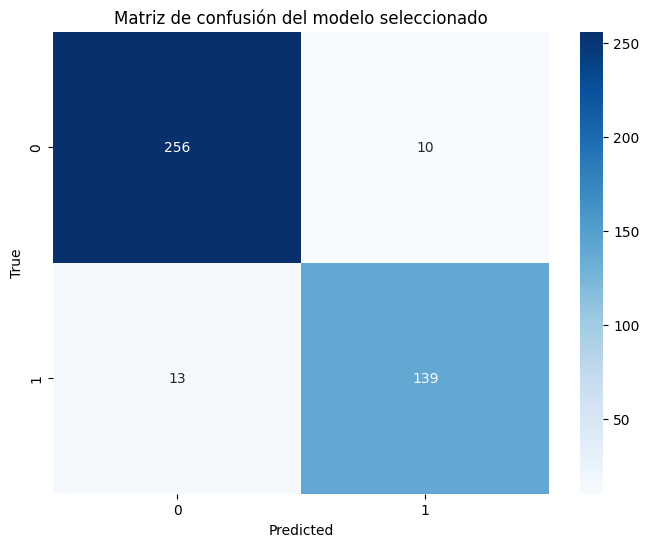

In [20]:
# Matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión del modelo seleccionado')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

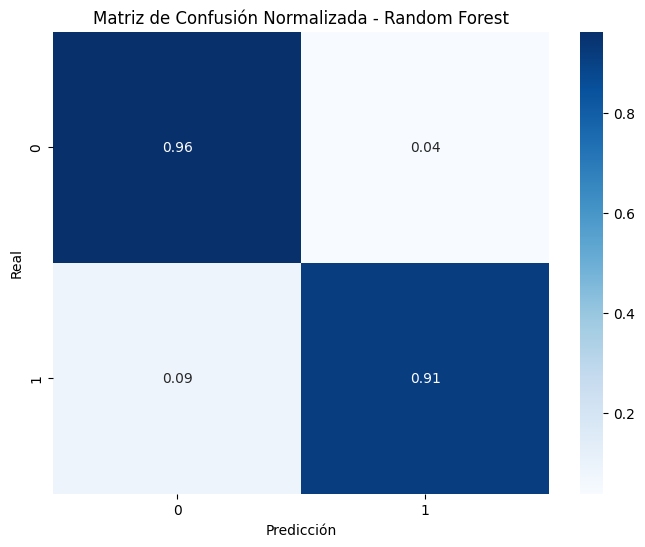

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0, 1], yticklabels=[0,1])
plt.title('Matriz de Confusión Normalizada - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

---
## Conclusión